# Foreign Exchange Carry Algorithm

Leo Luo

This project is to backtest a foreign exchange carry algorithm between 4 currencies, USD, EUR, GBP, AUD.


In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy as sp
import Quandl
import functools
import seaborn as sns
import ggplot as gg

In [ ]:
# Read Data, decided to use different sources.

In [ ]:
#save data to cache
@functools.lru_cache(maxsize=16)
def fetch_quandl(my_securities):
    qdata = Quandl.get(list(my_securities), trim_start='2002-01-01', trim_end='2016-04-21', collapse="weekly", 
                       returns="pandas", authtoken="*****")
    return qdata

#clean and make data look nicer
def clean_quandl_columns(dataframe):
    replacement_columns = {}
    for c in dataframe.columns:
        series_name, variable = c.split(' - ')
        source_name, asset = series_name.split('.')
        replacement_columns[c] = asset+":"+variable
    renamed_data = dataframe.rename(columns=replacement_columns)
    return renamed_data
#renamed_data = clean_quandl_columns(raw_data)
#renamed_data.tail()

In [ ]:
Read Data

In [33]:
da = pd.read_csv('AllRates.csv')
from datetime import datetime
f = lambda x: datetime.strptime(x, '%d/%m/%Y')
da['DATE'] = da['DATE'].astype(str)
da['DATE'] = da['DATE'].apply(f) 
da = da.set_index('DATE')
da.head()

,USD_Short,USD_Long1,USD_Long2,USD_Long5,EUR_Short,EUR_Long5,EUR_Long2,EUR_Long1,AUD_Short,GBP_Short,...,AUDUSD,USDEUR,USDGBP,USDAUD,EURGBP,AUDGBP,AUDEUR,GBPEUR,GBPAUD,EURAUD
DATE,,,,,,,,,,,,,,,,,,,,,
2002-01-11,0.018269,0.023400,0.0334,0.0488,0.03345,0.045895,0.039220,0.034365,0.0426,0.040477,...,0.521437,1.12121,0.691718,1.91836,0.617128,0.360631,0.584534,1.62060,2.77341,1.71063
2002-01-18,0.017700,0.022875,0.0335,0.0493,0.03345,0.045600,0.039125,0.035295,0.0423,0.040140,...,0.514550,1.13278,0.696215,1.94362,0.614639,0.358221,0.582859,1.62709,2.79192,1.71587
2002-01-25,0.018700,0.025000,0.0357,0.0509,0.03378,0.048165,0.041625,0.035205,0.0429,0.040210,...,0.517526,1.14934,0.706542,1.93294,0.614993,0.365648,0.594660,1.62613,2.73510,1.68190
2002-02-01,0.019200,0.025737,0.0350,0.0499,0.03375,0.046988,0.040810,0.037070,0.0431,0.040406,...,0.508922,1.16242,0.706794,1.96517,0.608136,0.359677,0.591430,1.64442,2.78056,1.69089
2002-02-08,0.019000,0.024188,0.0333,0.0487,0.03353,0.047083,0.040438,0.036385,0.0429,0.040284,...,0.510043,1.14652,0.706584,1.96077,0.616213,0.360361,0.584814,1.62288,2.77527,1.71014


In [34]:
# FUNCTIONS TO get the zero coupon bonds. from instructors note
def spot_rate(zcb, tenor):
    times = np.arange(tenor, 0, step=-0.5)[::-1]
    if times.shape[0]==0:
        sr = None
    else:
        r = np.interp(times, zcb.index.values, zcb.values) # Linear interpolation
        coupons_pv_x = 0.5*np.exp(-r*times).sum()
        final_pv = np.exp(-tenor*r[-1])
        sr = (1.0 - final_pv) / coupons_pv_x # Solves x + c * delta = 1.0
    return sr
def compute_spot_rates(zcb_rates):
    spot = zcb_rates.copy()
    for curve in zcb_rates.columns:
        zcb = zcb_rates[curve]
        for tenor, rate in zcb.iteritems():
            if tenor>0.001:
                spot[curve][tenor] = spot_rate(zcb, tenor)
    return spot
def bond_price(zcb, coupon_rate, tenor):
    times = np.arange(tenor, 0, step=-0.25)[::-1]
    if times.shape[0]==0:
        p = 1.0
    else:
        r = np.interp(times, zcb.index.values, zcb.values) # Linear interpolation
        p = np.exp(-tenor*r[-1]) + 0.5 * coupon_rate * np.exp(-r*times).sum()
    return p
def compute_zcb_curve(spot_rates_curve):
    zcb_rates = spot_rates_curve.copy()
    for curve in spot_rates_curve.columns:
        spot = spot_rates_curve[curve]
        for tenor, spot_rate in spot.iteritems():
            if tenor>0.001:
                times = np.arange(tenor-0.5, 0, step=-0.5)[::-1]
                coupon_half_yr = 0.5*spot_rate
                z = np.interp(times, zcb_rates[curve].index.values, zcb_rates[curve].values) # Linear interpolation
                preceding_coupons_val = (coupon_half_yr*np.exp(-z*times)).sum()
                zcb_rates[curve][tenor] = -np.log((1-preceding_coupons_val)/(1+coupon_half_yr))/tenor
    return zcb_rates

In [126]:
#Now is the Strategy part
# Cur_Short is the one to borrow, and use short coupon rate
# Cur_Long is the one to lend, and use long coupon rate
def CarryStrat(da, Cur_Short, Cur_Long):
    Short_rate = da[Cur_Short +'_Short'].copy()
    # this is the rate for the 5 year long for the short, this is for see if we need to go in the position
    Short5_rate = da[Cur_Short +'_Long5'] .copy()
    Long1_rate = da[Cur_Long +'_Long1'].copy()
    Long2_rate = da[Cur_Long +'_Long2'].copy()
    Long5_rate = da[Cur_Long +'_Long5'].copy()
    FX_rate = da[Cur_Short+Cur_Long].copy()
    pnl =[]
    tdate = []
    for i in range(len(Short_rate.index)-1):
        curtime = Short_rate.index[i]
        posttime = Short_rate.index[i+1]
        if abs(Short5_rate.ix[curtime] - Long5_rate.ix[curtime]) > 0.005:
            ret = 0
        else:
            rates = pd.DataFrame({
                         'Rate':[ Long1_rate.ix[curtime], Long2_rate.ix[curtime], Long5_rate.ix[curtime]],
                         'Tenor':[1,2,5]}).set_index(['Tenor'])
            zcb = compute_zcb_curve(rates)            
            receive = (10*FX_rate.ix[curtime]/(bond_price(zcb['Rate'], Long5_rate.ix[curtime], 5)))*(bond_price(zcb['Rate'], Long5_rate.ix[curtime], 5-1/52))/FX_rate.ix[posttime]
            paid = 8*(1+(Short_rate[curtime]+0.005)/52)
            ret = (receive - paid-2)/2    # 2 is the initial capital    
        pnl.append(ret)
        tdate.append(curtime)
    return pnl, tdate

In [127]:
# USD - EUR
Short_LongPair = [('USD' , 'EUR'),('USD' , 'GBP'),('GBP' , 'USD'),('GBP' , 'EUR'),('EUR' , 'USD'),
                 ('EUR' , 'GBP')]
len(Short_LongPair)

6

## Weekly Return

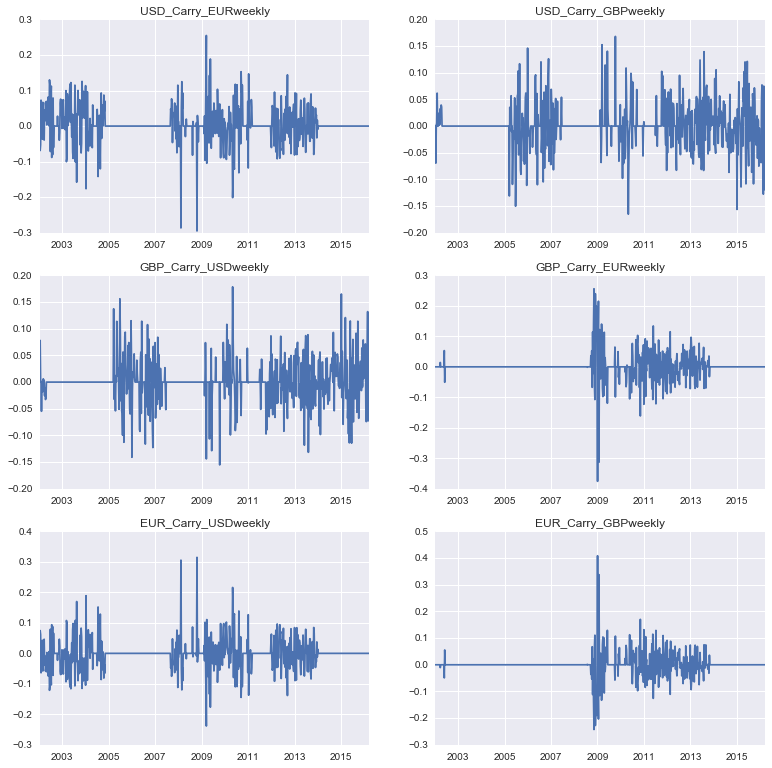

In [128]:
#weekly return rate
fig,axn = plt.subplots(3, 2, figsize=(13,13))
for i, ax in enumerate(axn.flat):
    Cur_Short, Cur_Long= Short_LongPair[i] #'USD' , 'EUR'
    pnl1, tdate1 = CarryStrat(da, Cur_Short, Cur_Long)   
    #cumpnl = np.cumsum(pnl1)
    pnl = pd.DataFrame(pnl1, index = tdate1, columns=[Cur_Short+'_Carry_'+Cur_Long])
    #plt.subplot(211)
    ax.plot(pnl)
    ax.set_title(Cur_Short+'_Carry_'+Cur_Long+'weekly')


## Cumulative Return

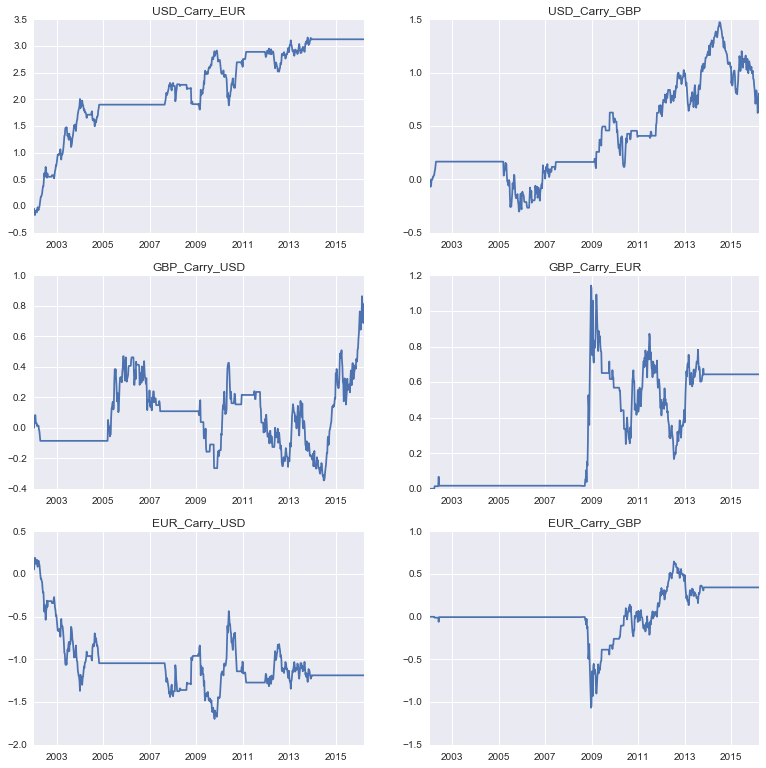

In [129]:
fig,axn = plt.subplots(3, 2, figsize=(13,13))
for i, ax in enumerate(axn.flat):
    Cur_Short, Cur_Long= Short_LongPair[i] #'USD' , 'EUR'
    pnl1, tdate1 = CarryStrat(da, Cur_Short, Cur_Long)   
    cumpnl = np.cumsum(pnl1)
    pnl = pd.DataFrame(cumpnl, index = tdate1, columns=[Cur_Short+'_Carry_'+Cur_Long])
    #plt.subplot(211)
    ax.set_title(Cur_Short+'_Carry_'+Cur_Long)
    ax.plot(pnl) #, label =Cur_Short+'_Carry_'+Cur_Long)

## Sharpe Ratio


In [133]:
#fig,axn = plt.subplots(3, 2, figsize=(13,13))
for i, ax in enumerate(axn.flat):
    Cur_Short, Cur_Long= Short_LongPair[i] #'USD' , 'EUR'
    pnl1, tdate1 = CarryStrat(da, Cur_Short, Cur_Long)   
    cumpnl = np.cumsum(pnl1)
    pnl = pd.DataFrame(cumpnl, index = tdate1, columns=[Cur_Short+'_Carry_'+Cur_Long])
    #plt.subplot(211)
    sharpe_ratio = float(pnl.mean()/float(pnl.std()))
    print (Cur_Short+'_Carry_'+Cur_Long + 'Sharpe' +str(sharpe_ratio))
    #ax.plot(pnl) #, label =Cur_Short+'_Carry_'+Cur_Long)

USD_Carry_EURSharpe2.915785831141375
USD_Carry_GBPSharpe1.0004501830247015
GBP_Carry_USDSharpe0.35326752321090815
GBP_Carry_EURSharpe1.0285388708230956
EUR_Carry_USDSharpe-3.4695898635861595
EUR_Carry_GBPSharpe0.22316619769168466


## Sortino Ratio

In [137]:
#fig,axn = plt.subplots(3, 2, figsize=(13,13))
for i, ax in enumerate(axn.flat):
    Cur_Short, Cur_Long= Short_LongPair[i] #'USD' , 'EUR'
    pnl1, tdate1 = CarryStrat(da, Cur_Short, Cur_Long)   
    cumpnl = np.cumsum(pnl1)
    pnl = pd.DataFrame(cumpnl, index = tdate1, columns=[Cur_Short+'_Carry_'+Cur_Long])
    #plt.subplot(211)
    sortino = float(pnl.mean())/float(pnl[pnl<0].dropna().std())
    print (Cur_Short+'_Carry_'+Cur_Long + 'Sharpe' +str(sortino))
    #ax.plot(pnl) #, label =Cur_Short+'_Carry_'+Cur_Long)

USD_Carry_EURSharpe49.878269401173036
USD_Carry_GBPSharpe5.337969287155239
GBP_Carry_USDSharpe1.0455770972091156
GBP_Carry_EURSharpenan
EUR_Carry_USDSharpe-4.120284189062132
EUR_Carry_GBPSharpe0.3023146886522005


## Rolling Year

C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:7: FutureWarning: pd.rolling_sum is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(center=False,window=52).sum()


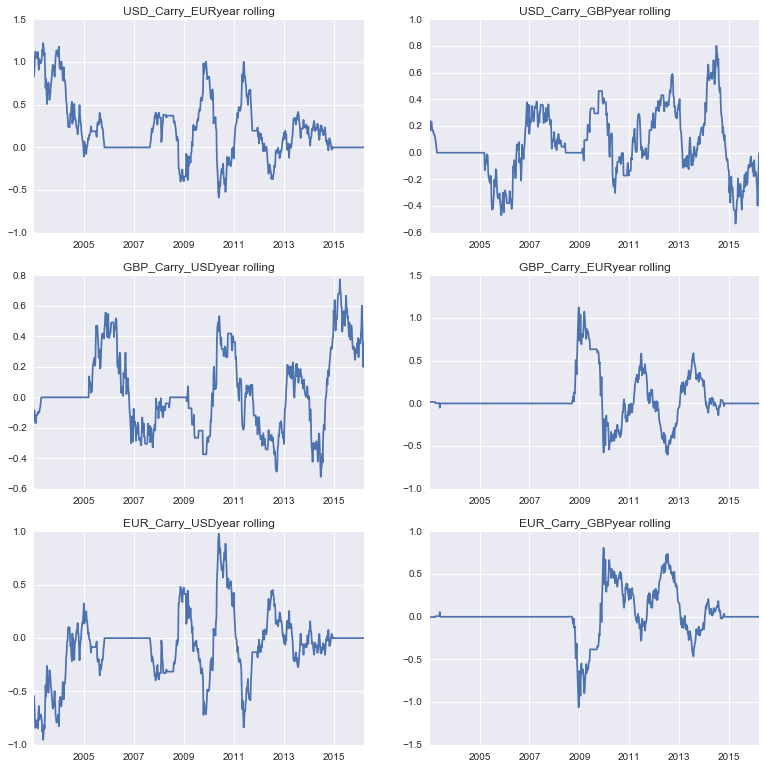

In [139]:
fig,axn = plt.subplots(3, 2, figsize=(13,13))
for i, ax in enumerate(axn.flat):
    Cur_Short, Cur_Long= Short_LongPair[i] #'USD' , 'EUR'
    pnl1, tdate1 = CarryStrat(da, Cur_Short, Cur_Long)   
    #cumpnl = np.cumsum(pnl1)
    pnl = pd.DataFrame(pnl1, index = tdate1, columns=[Cur_Short+'_Carry_'+Cur_Long])
    Running_Cumulative_1_Year_Weekly_Return = pd.rolling_sum(pnl, window = 52)
    Running_Cumulative_1_Year_Weekly_Return.dropna()
    #plt.subplot(211)
    ax.set_title(Cur_Short+'_Carry_'+Cur_Long+ 'year rolling')
    ax.plot(Running_Cumulative_1_Year_Weekly_Return) #, label =Cur_Short+'_Carry_'+Cur_Long)
#plt.plot(Running_Cumulative_1_Year_Weekly_Return.index,Running_Cumulative_1_Year_Weekly_Return['return rate'])